# Calculated power for adult univariate contrasts 
### Univariate contrast to measure boundary response across regions of interest (ROI)
#### Measure: Univariate difference from zero at event boundaries across ROIs-T-test

#### Reagh et al., 2020 
In this study the authors performed univariate contrasts for boundary response in a movie with a similar number of boundary timepoints i.e., 19 compared to our 12, across a number of similar ROIs that we will be using in our analysis.

Below, we took the data points for the young group and randomly sampled subsets of participants of different sizes to measure how many participants were needed to achieve the effect seen in the paper. Next, we compare the effect size seen in this paper with an effect size that is lower than the effect seen in the paper to establish a minimum number of participants needed to see an effect in adults.

In [5]:
# load modules
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.power import FTestAnovaPower, TTestIndPower, TTestPower
from pingouin import ttest, anova
import pingouin as pg
data_dir = 'plots_from_papers'

/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/anthonydutcher/anaconda3/envs/TA/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
nsim = 1000
adult_file = 'reagh_2020_adults/reagh_2020_adults_boundary.csv'
full_file = os.path.join(data_dir, adult_file)
df = pd.read_csv(full_file, sep='\s+', index_col=False)
rois = ['PMC', 'aHPC', 'pHPC', 'mPFC', 'ANG', 'PHC']
test_list = list()
for frac in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    for sim in range(nsim):
        sdf = df.sample(frac=frac)
        for roi in rois:  
            tt = ttest(sdf.loc[:, roi].values, 0)
            tt['roi'] = roi
            tt['samples'] = len(sdf)
            test_list.append(tt)

univariate_tt_full = pd.concat(test_list)
None

Text(0.5, 0.98, 'Power and effect size estimates across ROIs for different sample sizes')

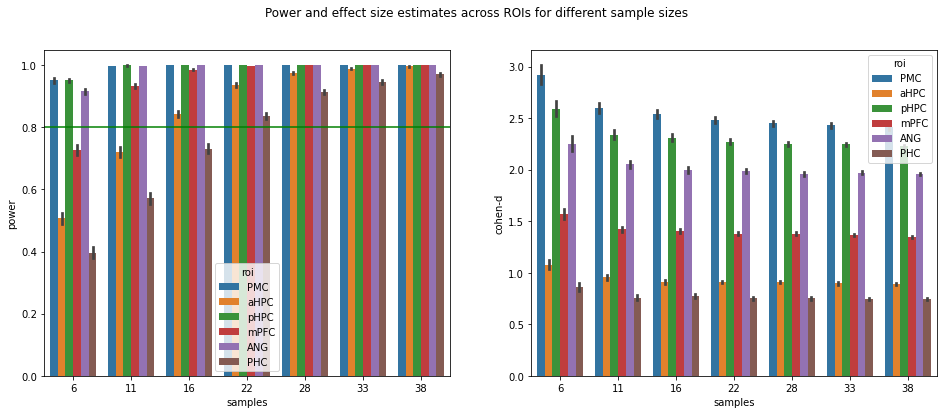

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.barplot(ax=ax[0], data=univariate_tt_full, x='samples', y='power', hue='roi')
sns.barplot(ax=ax[1], data=univariate_tt_full, x='samples', y='cohen-d', hue='roi')
ax[0].axhline(0.8, color='g')
fig.suptitle('Power and effect size estimates across ROIs for different sample sizes')
None

## Summary of univariate power analysis in adults.
The effect size found in Reagh et al., 2020 is strong and they only needed around 22 participants to see their actual effect of interest across ROIs. Our sample will have 30 participants, even if our effect size is not as strong i.e., 0.55 instead of around 0.8 we would have enough power to see our desired effect in adults.

# Calculated power for developmental univariate contrasts 

### Univariate contrast to measure developmental differences in boundary response across ROIs
#### Measure: Univariate difference between groups at event boundaries across ROIs - Independent samples T-test

#### Golarai et al. 2007
- prenumbra area in posterior place area (ppa) - PHC

In Golarai et al. 2007, the participant breakdown is:
- 10 children, 7-11 years, (average age = ??.??)
- 13 adults, (average age = ??.??)


In [8]:
# utility
def simulate_bar_graph_data(file, n_child, n_adult, se=False):
    """ 
    Utility function for pulling information from a bar 
    graph represented as a datafrane with 4 rows: 
        row 1 - mean child
        row 2 - mean + se (or sd) child
        row 3 - mean adult
        row 4 - mean + se (or sd) adult
    """
    tmp1 = pd.read_csv(file, header=None)
    tmp1.columns = ['dtype', 'value']
    
    tmp2 = pd.DataFrame({ 'group': ['child', 'adult'], 
                          'mean_val':[tmp1.value[0], tmp1.value[2]], 
                          'sd_val':[tmp1.value[1] - tmp1.value[0], tmp1.value[3] - tmp1.value[2]]})
    grp = np.hstack([ np.repeat(['child'], n_child), np.repeat(['adult'], n_adult)]).squeeze()
    if se is True:
        sd1 = tmp2.sd_val[0] * np.sqrt(n_child)
        sd2 = tmp2.sd_val[1] * np.sqrt(n_adult)
        vals = np.hstack(
            [ np.random.normal(tmp2.mean_val[0], sd1, n_child).reshape([1 ,n_child]), 
              np.random.normal(tmp2.mean_val[1], sd2, n_adult).reshape([1, n_adult])] ).squeeze()
    
    else:
        vals = np.hstack(
            [ np.random.normal(tmp2.mean_val[0], tmp2.sd_val[0], n_child).reshape([1 ,n_child]), 
              np.random.normal(tmp2.mean_val[1], tmp2.sd_val[1], n_adult).reshape([1, n_adult])] ).squeeze()
    sim_df = pd.DataFrame([grp, vals], index=['group', 'values']).T
    sim_df['values'] = sim_df['values'].astype('float')
    return sim_df

In [9]:
n_child = 10
n_adult = 13
phc_file = 'golarai_2008/golarai_prenumbra5_ppa_kid-adult.csv'
full_file = os.path.join(data_dir, phc_file)
n_small_sims = 1000
test_list = list()    
for sim in range(n_small_sims):    
    # calculate effect size
    df = simulate_bar_graph_data(full_file, n_child, n_adult, se=False)
    av = anova(data=df, dv='values', between='group')
    effect_size = av.np2[0]

    # other parameters
    power = 0.8
    alpha = 0.05
    power_analysis = FTestAnovaPower()
    sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                             power = power, 
                                             alpha = alpha)
    av['samples'] = sample_size
    test_list.append(av)
    
dev_diff = pd.concat(test_list)

In [12]:
ef = dev_diff['np2'].mean()
print(f"Effect size difference between children and adults = {ef.round(3)}")

Effect size difference between children and adults = 0.847


### Summary from developmental univariate contrasts (Golarai et al. 2007).
Strong effect size, smaller sample.


#### Ofen et al. 2012
- Values taken from posterior parietal cortex (ppc)

In Ofen et al. 2012, the participant breakdown is:
- 27 children, 7-11 years
- 32 adults

Here, the standard deviation is simulated at different levels because it was not provided and could not be deduced from the data points.

In [13]:
uni_adults_PAR = os.path.join(data_dir, 'ofen_2012/ofen_2012_parietal_mem_resp_adults.csv')
uni_kids_PAR = os.path.join(data_dir, 'ofen_2012/ofen_2012_parietal_mem_resp_kids.csv')
uni_ages_PAR = os.path.join(data_dir, 'ofen_2012/ofen_2012_ages.csv')
max_val_kids = pd.read_csv(uni_kids_PAR, header=None).max()[1] # the highest average across time series
max_val_adults = pd.read_csv(uni_adults_PAR, header=None).max()[1] # the highest average across time series
ages = pd.read_csv(uni_ages_PAR, header=None)[1]
tests = list()
kid_sds = np.linspace(0.3, .1, 6)
n_kids = 27
n_adults = 32
nsim = 1000
for sd in kid_sds:
    for sim in range(nsim):
        par_resp = np.hstack([np.random.normal(max_val_kids, sd, n_kids).reshape([1,n_kids]), np.random.normal(max_val_adults, sd, n_adults).reshape([1,n_adults])])
        labels = np.hstack([np.repeat(['kid'], n_kids), np.repeat(['adult'],n_adults)])
        df = pd.DataFrame([par_resp[0], labels]).T
        df.columns = ['parietal resp', 'group']
        df['parietal resp'] = df['parietal resp'].astype('float')
        av = anova(data=df, dv='parietal resp', between='group')
        tests.append(np.array([sd, n_kids, n_adults, av.F[0], av.np2[0]]))

av = pd.DataFrame(tests, columns=['sd', 'N kid', 'N adult', 'F', 'es'])

Minimum effect size : 0.572


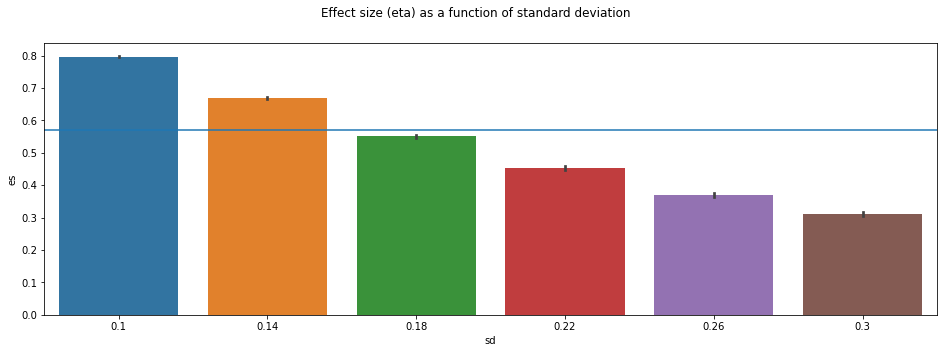

In [14]:
# getting example sample size for an expected effect size
power = 0.8
alpha = 0.05
result = TTestPower().solve_power(power=power, nobs=26, alpha=alpha)
print(f'Minimum effect size : {result:.3f}')

fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data=av, x='sd', y='es')
plt.suptitle('Effect size (eta) as a function of standard deviation')
ax.axhline(result)
None

#### Scherf et al. 2007
Naturalistic stimuli of 4 categories of items distributed randomly across 32 15-seconod blocks (8 instances of each category). From the paper: "The vignettes were organized into 32 randomized 15-second blocks containing stimuli from a single category."

## Summary of developmental differences in univariate response.
Both studies sampled here found significant results with different sample sizes, with the difference in effect size driving effects, suggesting the underlying signal that is being sampled is important. As no studies to date have measured developmental differences in event boundaries for naturalistic stimuli our adult work suggests we are sufficiently powered to see effects if they exist. The minimum effect size needed in our sample size of 56 would be 0.536. This effect size was exhibited in Golarai et al., 2007 but in Ofen et al. 2012 the authors did not report participant level data and so had to be deduced by simulating different standard deviations. 
